In [124]:
import os
import sys

cwd = os.getcwd()
print("cwd:",cwd)

### USE ASI KERNEL ###

#!python3 -m venv '../venvs/asi'
#!source '../venvs/asi/bin/activate'

print(sys.prefix, sys.base_prefix)

cwd: /home/tcp/asi_code
/home/tcp/venvs/asi /usr


#### Generate MG data

In [125]:
import numpy as np
import csv
from math import floor

def Df(x):
    a=0.2
    y=a*x/(1+x**10)
    return y

def MackeyGlass(N, tau, pred_time_step=1 ,time_interval=1):

    x = np.zeros((N,))
    t = np.zeros((N,))
    pred_time_step = pred_time_step
    b=0.1
    h = time_interval
    x[0] = 1.2
    for k in range(N-1):
        t[k+1] = t[k]+h
        if k < tau:
            k1 = -b*x[k]
            k2 = -b*(x[k]+h*k1/2);
            k3 = -b*(x[k]+k2*h/2);
            k4 = -b*(x[k]+k3*h);
            x[k+1] = x[k]+(k1+2*k2+2*k3+k4)*h/6;
        else:
            n = floor((t[k]-tau-t[0])/h+1);
            k1 = Df(x[n])-b*x[k];
            k2 = Df(x[n])-b*(x[k]+h*k1/2);
            k3 = Df(x[n])-b*(x[k]+2*k2*h/2);
            k4 = Df(x[n])-b*(x[k]+k3*h);
            x[k+1] = x[k]+(k1+2*k2+2*k3+k4)*h/6;
    y = x[2000+pred_time_step:5000+pred_time_step]
    u = x[2000:5000]
    return y,u

#### Save MG data

In [126]:
import os

prediction_steps = 8
csv_file_path = 'mackeyglass_'+str(prediction_steps)+'_3000samples.csv'

force_generate_input_data = 0

if (not os.path.isfile(csv_file_path)) or force_generate_input_data==True:
    y, u = MackeyGlass(6000, 17, pred_time_step=prediction_steps)
    data = list(zip(y, u))
    
    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['y', 'u'])
        
        csv_writer.writerows(data)
        
        print(f'Data has been successfully written to {csv_file_path}.')
else:
    print("MG input signal file exists:", csv_file_path)

MG input signal file exists: mackeyglass_8_3000samples.csv


#### Load Data

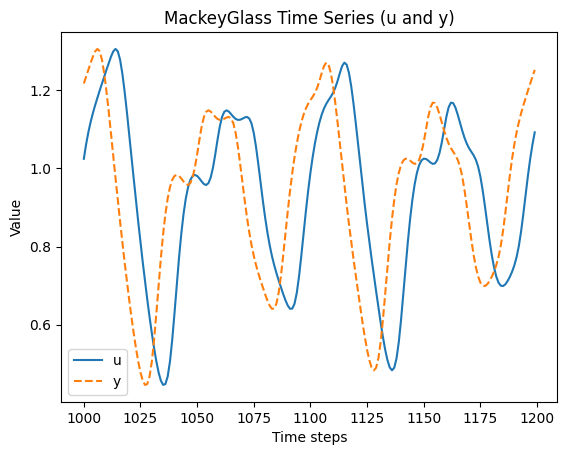

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

filename = 'mackeyglass_'+str(prediction_steps)+'_3000samples.csv'

# Read the CSV data into a DataFrame
df = pd.read_csv(filename)

# Access data by column names
y_data = df["y"]
u_data = df["u"]

# Visualize
plt.plot(u_data[1000:1200], label="u")
plt.plot(y_data[1000:1200], label="y", linestyle='--')
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.title("MackeyGlass Time Series (u and y)")
plt.legend()
plt.show()

#### Normalize Data

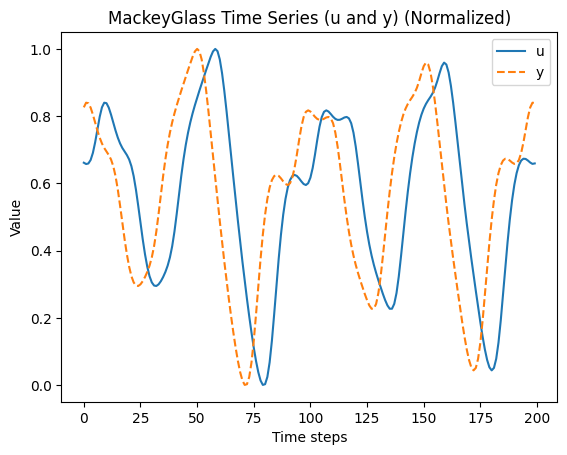

In [128]:
import numpy as np

# Normalize
u_values = u_data.values
y_values = y_data.values
u_data_max = np.max(u_values)
u_data_min = np.min(u_values)
y_data_max = np.max(y_values)
y_data_min = np.min(y_values)

u_norm = (u_values - u_data_min) / (u_data_max - u_data_min)
y_norm = (y_values - y_data_min) / (y_data_max - y_data_min)

# Visualize
plt.plot(u_norm[1350:1550], label="u")
plt.plot(y_norm[1350:1550], label="y", linestyle='--')
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.title("MackeyGlass Time Series (u and y) (Normalized)")
plt.legend()
plt.show()

In [129]:
print(len(y_data))
print(len(u_data))
print(y_data[1:10])
print(u_data[1:10])
print(y_data.shape)

3000
3000
1    0.775433
2    0.804915
3    0.843353
4    0.889212
5    0.938197
6    0.985518
7    1.027950
8    1.064296
9    1.094857
Name: y, dtype: float64
1    0.706835
2    0.699470
3    0.698930
4    0.703695
5    0.712210
6    0.723358
7    0.736861
8    0.753565
9    0.775433
Name: u, dtype: float64
(3000,)


#### Create ASI model

In [130]:
from flatspin.model import *

size = (7,7)
hc = 200e-3
sw_b = 0.41
sw_c = 1
sw_beta = 1.5
alpha = 3e-5
sw_gamma = 3.9
disorder = 0.05
use_gpu = 1
pinWheelIceDiamond = PinwheelSpinIceDiamond(size=size, hc=hc, sw_b=sw_b, sw_c=sw_c, sw_beta=sw_beta, alpha=alpha, sw_gamma=sw_gamma, disorder=disorder, use_cuda=use_gpu)
squareIce = SquareSpinIceClosed(size=size, hc=hc, sw_b=sw_b, sw_c=sw_c, sw_beta=sw_beta, alpha=alpha, sw_gamma=sw_gamma, disorder=disorder, use_cuda=use_gpu)

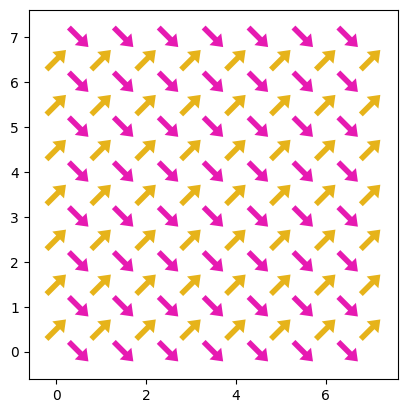

In [131]:
pinWheelIceDiamond.plot()

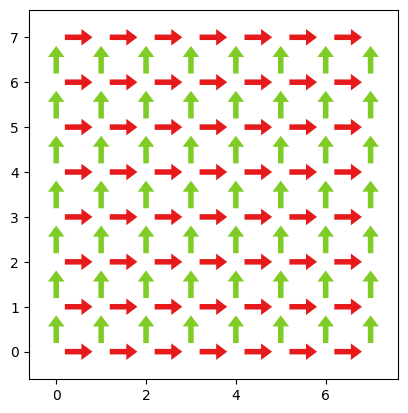

In [132]:
squareIce.plot()

#### Set up Encoders

In [133]:
from flatspin.encoder import *

encoder_type = "Constant"

# Constant Encoder
H0 = 55e-3
H = 80e-3
timesteps = 1

# Angle Encoder
phi0=7
phi = 97

# Magnitude mapping: [0, 1] -> [H0, H]
constantEncoder = Constant(H0=H0, timesteps=timesteps)
constantEncoder.set_params(H=H)

# Angle between [phi0, phi]. Fixed magnitude H
angleEncoder = Angle(phi0=phi0, phi=phi)
angleEncoder.set_params(H=H)

#### Generate Analog Readout

In [134]:
from tqdm import tqdm

# timesteps=1 -> one encoded value for each input value
def encode_inp_as_field(input_signal):
    encode = constantEncoder
    # print("Input Signal", input_signal)
    # h_input = self.Hc+self.Hr*input_signal
    # encode_h_input = {'H0': self.Hc, 'H':h_input}
    input_signal = input_signal
    # print('Input Signal', input_signal)
    h_ext = encode(input_signal) # encode input signal as external magnetic field

    # print("H Ext", h_ext)
    return h_ext

# N identical encoded pairs ({num, -num} repeated N times) for each input value
def encode_inp_as_field_cycle(input_signal, N=5):
    encode = constantEncoder
    # print("Input Signal", input_signal)
    # h_input = self.Hc+self.Hr*input_signal
    # encode_h_input = {'H0': self.Hc, 'H':h_input}
    input_signal = input_signal
    # print('Input Signal', input_signal)
    h_ext = encode(input_signal) # encode input signal as external magnetic field

    cycled_h_ext = []
    for num in h_ext:
        for i in range(1, N+1):
            cycled_h_ext.append(num)
            cycled_h_ext.append(-num)
    return cycled_h_ext

def generate_asi_sates(states_of_asi_square, states_of_asi_pinwheel):
    #states_of_asi_square = np.zeros((len(col3_u_norm),len(squareIce.spin)))
    #states_of_asi_pinwheel = np.zeros((len(col3_u_norm),len(pinWheelIceDiamond.spin)))
    asi_squareice = squareIce # for each new input signal asi_model should be in the intial state
    asi_pinwheel  = pinWheelIceDiamond
    asi_squareice.randomize()
    asi_pinwheel.randomize()
    
    for input_signal_no in tqdm(range(len(u_norm))):
        
        h_ext = encode_inp_as_field_cycle(u_norm[input_signal_no])
        # print(h_ext)
        for i, h in enumerate(h_ext):
            asi_squareice.set_h_ext(h)
            asi_pinwheel.set_h_ext(h)
            flips_square = asi_squareice.relax()
            flips_pinwheel = asi_pinwheel.relax()
        output_states_square = []
        output_states_pinwheel = []
        
        
        for i in range(len(squareIce.spin)):
            # print(asi_squareice.total_field(i))
            hx, hy = asi_squareice.total_field(i)
            field_amp = np.sqrt(hx**2 + hy**2)
            output_states_square.append(field_amp)
            #output_states_square.append(field_amp*asi_squareice.spin[i])
            # print(f"field_amp = {field_amp}")
        for i in range(len(asi_pinwheel.spin)):
            # print(asi_pinwheel.total_field(i))
            hx, hy = asi_pinwheel.total_field(i)
            field_amp = np.sqrt(hx**2 + hy**2)
            output_states_pinwheel.append(field_amp)
            #output_states_pinwheel.append(field_amp*asi_pinwheel.spin[i])
            # print(f"field_amp = {field_amp}")
        # output_states_square = asi_squareice.spin
        # output_states_pinwheel = asi_pinwheel.spin
        # print(output_states_square)
        # print(output_states_pinwheel)
        states_of_asi_square[input_signal_no, :] = output_states_square
        states_of_asi_pinwheel[input_signal_no, :] = output_states_pinwheel
        
force_generate_states = 0

states_of_asi_square = np.zeros((len(u_norm),len(squareIce.spin)))
states_of_asi_pinwheel = np.zeros((len(u_norm),len(pinWheelIceDiamond.spin)))

states_square_file = 'states_of_asi_square_mg'
states_pinwheel_file = 'states_of_asi_pinwheel_mg'

if (not os.path.isfile(states_square_file+'.npy')) or (not os.path.isfile(states_pinwheel_file+'.npy')) or force_generate_states==True:
    generate_asi_sates(states_of_asi_square, states_of_asi_pinwheel)
    
    np.save(states_square_file, states_of_asi_square)
    np.save(states_pinwheel_file, states_of_asi_pinwheel)
    print(states_of_asi_square)
    print(states_of_asi_pinwheel)
else:
    print("asi state files exist.")

print("Shape of  Input", u_norm.shape)
print("Shape of  Square Ice X", states_of_asi_square.shape)
print("Shape of  Pinwheel X", states_of_asi_pinwheel.shape)

asi state files exist.
Shape of  Input (3000,)
Shape of  Square Ice X (3000, 112)
Shape of  Pinwheel X (3000, 112)


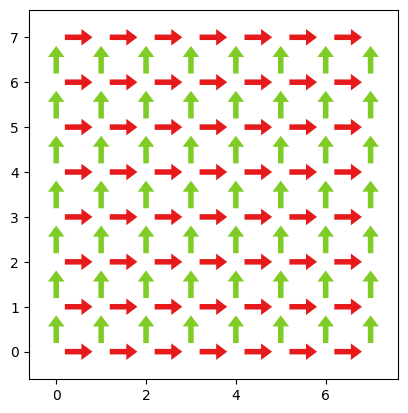

In [135]:
squareIce.plot()

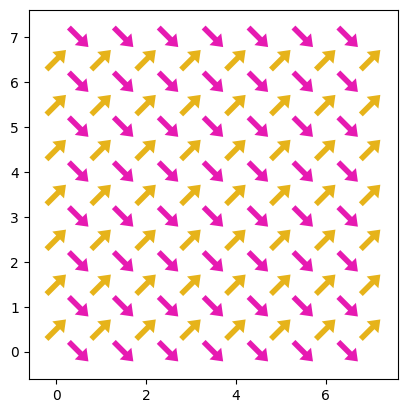

In [136]:
pinWheelIceDiamond.plot()

#### Read Output States

In [137]:
import numpy as np

data_squareice = np.load(states_square_file+'.npy')

data_pinwheelice = np.load(states_pinwheel_file+'.npy')


# Display the values
print(data_squareice)
print(data_pinwheelice)

print("Shape of  Square Ice X", data_squareice.shape)
print("Shape of  Pinwheel X", data_pinwheelice.shape)

[[0.06269008 0.06294469 0.06331919 ... 0.06325919 0.06281008 0.06319919]
 [0.06224664 0.06250126 0.06287576 ... 0.06281576 0.06236664 0.06275576]
 [0.06203268 0.0622873  0.0626618  ... 0.0626018  0.06215268 0.0625418 ]
 ...
 [0.06256051 0.06275512 0.06318963 ... 0.06324963 0.06268051 0.06318963]
 [0.06119689 0.06139151 0.06182601 ... 0.06188601 0.06131689 0.06182601]
 [0.05990147 0.06009608 0.06053058 ... 0.06059058 0.06002147 0.06053058]]
[[0.06278286 0.06296853 0.06324124 ... 0.06317279 0.06291306 0.06316123]
 [0.06233943 0.0625251  0.06279781 ... 0.06272936 0.06246962 0.0627178 ]
 [0.06212547 0.06231113 0.06258385 ... 0.06251539 0.06225566 0.06250384]
 ...
 [0.06297269 0.06296422 0.06308325 ... 0.06307279 0.06310387 0.06313486]
 [0.06160908 0.06160061 0.06171964 ... 0.06170918 0.06174026 0.06177125]
 [0.06031365 0.06030518 0.06042421 ... 0.06041376 0.06044484 0.06047583]]
Shape of  Square Ice X (3000, 112)
Shape of  Pinwheel X (3000, 112)


#### Generate time-delayed state data

In [138]:
def gen_time_delayed_data(data_in, len_hist):
    len_time, len_signal = data_in.shape
    #print(len_time, len_signal)
    data_out = np.zeros((len_time - len_hist, len_signal * len_hist))
    #print(data_out.shape)
    for i in range(len_hist, len_time):
        for j in range(len_hist):
            data_out[i-len_hist, j*len_signal:(j+1)*len_signal] = data_in[i-j, :]
    return data_out

history_len = 50
states_of_asi_square = gen_time_delayed_data(data_squareice, history_len)
states_of_asi_pinwheel = gen_time_delayed_data(data_pinwheelice, history_len)
#states_of_asi_square = data_squareice
#states_of_asi_pinwheel = data_pinwheelice

# Display data stats
print(states_of_asi_square)
print(states_of_asi_pinwheel)

print(np.max(states_of_asi_square), np.min(states_of_asi_square))
print(np.max(states_of_asi_pinwheel), np.min(states_of_asi_pinwheel))

print("Shape of  Square Ice X", states_of_asi_square.shape)
print("Shape of  Pinwheel X", states_of_asi_pinwheel.shape)

[[0.05465673 0.05485136 0.05528585 ... 0.06281576 0.06236664 0.06275576]
 [0.05475948 0.0549541  0.05538859 ... 0.0626018  0.06215268 0.0625418 ]
 [0.05535378 0.0555484  0.05598289 ... 0.06258613 0.06213701 0.06252613]
 ...
 [0.06256051 0.06275512 0.06318963 ... 0.07096965 0.07040053 0.07090965]
 [0.06119689 0.06139151 0.06182601 ... 0.0699969  0.06942778 0.0699369 ]
 [0.05990147 0.06009608 0.06053058 ... 0.06882214 0.06825302 0.06876214]]
[[0.05506619 0.05508003 0.05519477 ... 0.06272936 0.06246962 0.0627178 ]
 [0.05516893 0.05518277 0.05529752 ... 0.06251539 0.06225566 0.06250384]
 [0.05576323 0.05577707 0.05589182 ... 0.06249972 0.06223999 0.06248817]
 ...
 [0.06297269 0.06296422 0.06308325 ... 0.07074554 0.07080904 0.07085748]
 [0.06160908 0.06160061 0.06171964 ... 0.06977279 0.06983629 0.06988473]
 [0.06031365 0.06030518 0.06042421 ... 0.06859803 0.06866153 0.06870997]]
0.08062911688245432 0.05437088311754568
0.08044012436180262 0.05467168139538843
Shape of  Square Ice X (2950, 56

#### Train Linear Layer with Reservoir States

In [139]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
from torchinfo import summary

torch.manual_seed(seed=2345678)

train_epochs = 1000

class LinearLayer():

    def __init__(self, X, Y):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.X = torch.tensor(X).to(self.device)
        self.Y = torch.tensor(Y).to(self.device)

    def train(self, nodes, batch_size=256, bias=False):
        train_ds = TensorDataset(self.X, self.Y)
        train_dl = DataLoader(train_ds, batch_size, shuffle=True)
        hidden_layer_size = int(nodes/history_len)
        model = nn.Sequential(
            nn.Linear(nodes, hidden_layer_size),
            nn.SELU(),
            nn.Linear(hidden_layer_size, 1) )
        #model = nn.Sequential(nn.Linear(nodes, 1, bias=bias), nn.SELU())
        #model = nn.Linear(nodes, 1, bias=bias) # Linear Model
        #model.weight.data = torch.randn(model.weight.size())*0.01
        #if bias==True:
        #    model.bias.data = torch.randn(model.bias.size())*0.01
        model.to(self.device)
        opt = optim.SGD(model.parameters(), lr=1e-3) # Optimising Algorithm
        
        #print(summary(model, input_size=(batch_size, 2048, 112)))
        #self.print_model(model)
        #return
        
        y_hat_before = model(self.X.float()).detach().cpu().numpy()
        y_hat_before = (y_hat_before - np.min(y_hat_before)) / (np.max(y_hat_before) - np.min(y_hat_before))  # Min-Max normalization


        # print('Y Hat Before Training ', y_hat_before)
        loss_fn1 = F.mse_loss # Loss Function
        loss_fn2 = self.correlation # F.mse_loss # Loss Function

        trained_losses, self.trained_model = self.fit(train_epochs, model, opt, train_dl, loss_fn1, loss_fn2)
        print("Training completed")
        _Ybar = self.trained_model(self.X.float()).detach().cpu().numpy()
        #_Ybar = _Ybar.flatten()
        print('Predicted Y Hat After Training ')
        _Ybar = (_Ybar - np.min(_Ybar)) / (np.max(_Ybar) - np.min(_Ybar))  # Min-Max normalization
        _Y = self.Y.detach().cpu().numpy()
        #_Y = (_Y - np.min(_Y)) / (np.max(_Y) - np.min(_Y))  # Min-Max normalization
        # print(len(_Ybar))
        # print(len(_Y))
        mse_loss = self.mean_square_error(_Ybar,_Y)
        print('MSE LOSS :', mse_loss)
        nrmse_loss = self.NRMSE(_Ybar,_Y)
        #nrmse_loss = self.NRMSE(_Ybar[1000:2000],_Y[1000:2000])
        print('NRMSE LOSS :', nrmse_loss)
        numerator = np.sum(np.multiply(_Y-np.mean(_Y), _Ybar.flatten()-np.mean(_Ybar)))
        denominator = np.size(_Y)*np.std(_Y)*np.std(_Ybar)
        correlation_coefficient = numerator/denominator
        print("correlation_coefficient", correlation_coefficient)

        # plt.plot(u_norm[1000:1500], label="input u")
        #plt.plot(_Y[1300:1500], label="target y", color='blue')
        #plt.plot(y_hat_before[1300:1500], label="reproduced y", linestyle='--', color='green', linewidth=2.5)
        #plt.plot(_Ybar[1300:1500], label="predicted y", color='red', linewidth=1)
        #plt.xlabel("Time steps")
        #plt.ylabel("Value")
        #plt.title("Time Series")
        #plt.legend()
        #plt.show()
        
        #self.print_model(model)
        #self.print_model(self.trained_model)

        return y_hat_before, _Ybar, trained_losses, mse_loss, nrmse_loss, correlation_coefficient, self.trained_model
    
    def print_model(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
    
    def correlation(self, array1, array2):
        numerator = torch.sum(torch.multiply(array1-torch.mean(array1), array2-torch.mean(array2)))
        denominator = torch.numel(array1)*torch.std(array1)*torch.std(array2)
        return 1.0 - numerator/denominator

    def predict(self, rc_benchmark):
        _Ybar = self.trained_model(self.X.float()).detach().cpu().numpy()
        # _Y = self.Y.detach().cpu().numpy()
        return _Ybar
    def mean_square_error(self, array1, array2):
        squared_error = np.square(array1.flatten() - array2.flatten())
        mse = np.mean(squared_error)
        #print(array1.shape, array2.shape, squared_error.shape)
        return mse
    def NRMSE(self,y_pred, y_true):
        """
        Calculate the Normalized Root Mean Square Error (NRMSE) between two arrays.

        Parameters:
        y_true : array-like of shape (n_samples,)
            Ground truth (correct) target values.

        y_pred : array-like of shape (n_samples,)
            Estimated target values.

        Returns:
        nrmse : float
            Normalized Root Mean Square Error (NRMSE) value.
        """

        # Ensure inputs are numpy arrays
        y_true = np.array(y_true.flatten())
        y_pred = np.array(y_pred.flatten())

        # Calculate RMSE
        rmse = np.sqrt(np.mean((y_true - y_pred)**2))

        # Calculate range of the data
        data_range = np.max(y_true) - np.min(y_true)

        # Calculate NRMSE
        # nrmse = rmse
        nrmse = rmse / data_range

        return nrmse
    # def NRMSE(self, _Ybar,_Y):
    #     return np.sqrt(np.divide(
    #                  np.mean(np.square(_Y-_Ybar)),
    #                  np.var(_Y)))

    #  Model training function
    def fit(self, num_epochs, model, opt, train_dl, loss_fn1, loss_fn2):
        # Initialize empty list to store losses
        losses = []
        best_loss = 1e3
        best_epoch = 0
        best_model = copy.deepcopy(model)

        for epoch in tqdm(range(num_epochs)):
            total_loss = 0
            for xb, yb in train_dl:
                # Generate predictions
                pred = model(xb.float())
                # Normalize the Prediction
                #pred_min = torch.min(pred); pred_max = torch.max(pred)
                #pred = (pred - pred_min) / (pred_max - pred_min)
                
                # Calculate loss
                #loss = loss_fn1(pred.flatten(), yb.float())
                loss = loss_fn1(pred.flatten(), yb.float())*0.15 + loss_fn2(pred.flatten(), yb.float())*0.85
                # Append loss value to the list
                
                # Perform gradient descent
                loss.backward()
                opt.step()
                opt.zero_grad()
                
                total_loss += loss.item()
            losses.append(total_loss)
            
            if total_loss < best_loss:
                best_loss = total_loss
                best_epoch = epoch
                best_model = copy.deepcopy(model)
        
        print('Finished training', len(losses))
        print('Final Loss', losses[-1], '\nBest Loss', losses[best_epoch], 'at epoch', best_epoch)
        
        # Plot the loss progression
        #plt.plot(losses)
        #plt.xlabel("Training Steps")
        #plt.ylabel("Loss")
        #plt.title("Loss Progression During Training")
        #plt.show()

        return losses, best_model



#### Training and Results

In [140]:
train_len = 2048
X_square_train = states_of_asi_square[:train_len, :]
X_square_test = states_of_asi_square[train_len:, :]
X_pinwheel_train = states_of_asi_pinwheel[:train_len, :]
X_pinwheel_test = states_of_asi_pinwheel[train_len:, :]
y_norm_hist = y_norm[history_len:]
y_norm_train = y_norm_hist[:train_len]
y_norm_test = y_norm_hist[train_len:]

print("Shape of  X_train [Square Ice]:", X_square_train.shape)
print("Shape of  X_train [Pinwheel]:", X_pinwheel_train.shape)
print("Shape of  Y_train:", y_norm_train.shape)
print("Shape of  X_test [Square Ice]:", X_square_test.shape)
print("Shape of  X_test [Pinwheel]:", X_pinwheel_test.shape)
print("Shape of  Y_test:", y_norm_test.shape)

output_layer_square = LinearLayer(X_square_train, y_norm_train)
output_layer_pinwheel = LinearLayer(X_pinwheel_train, y_norm_train)
y_reprod_square, y_pred_square, losses_square, mse_square, nrmse_square, cc_square, model_square = output_layer_square.train(X_square_train.shape[1])
save_model_name = 'model_mg_square_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.pt'
torch.save(model_square, save_model_name)
# mse_square = output_layer_square.train()

print("Training MSE LOSS Square Ice", mse_square)
y_reprod_pinwheel, y_pred_pinwheel, losses_pinwheel, mse_pinwheel, nrmse_pinwheel, cc_pinwheel, model_pinwheel = output_layer_pinwheel.train(X_pinwheel_train.shape[1])
save_model_name = 'model_mg_pinwheel_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.pt'
torch.save(model_pinwheel, save_model_name)
# mse_pinwheel = output_layer_pinwheel.train(60)
print("Training MSE LOSS Pinwheel", mse_pinwheel)
# metric = output_layer_square.test('Narma10')
# print("NRMSE LOSS", metric)

Shape of  X_train [Square Ice]: (2048, 5600)
Shape of  X_train [Pinwheel]: (2048, 5600)
Shape of  Y_train: (2048,)
Shape of  X_test [Square Ice]: (902, 5600)
Shape of  X_test [Pinwheel]: (902, 5600)
Shape of  Y_test: (902,)


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.32it/s]


Finished training 1000
Final Loss 0.1468530222773552 
Best Loss 0.12474505603313446 at epoch 959
Training completed
Predicted Y Hat After Training 
MSE LOSS : 0.000612896439133881
NRMSE LOSS : 0.024756745325948664
correlation_coefficient 0.9957391294523538
Training MSE LOSS Square Ice 0.000612896439133881


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.69it/s]

Finished training 1000
Final Loss 0.13736073672771454 
Best Loss 0.12288412544876337 at epoch 963
Training completed
Predicted Y Hat After Training 
MSE LOSS : 0.0004658450840054158
NRMSE LOSS : 0.021583444674226952
correlation_coefficient 0.9967662603824853
Training MSE LOSS Pinwheel 0.0004658450840054158


In [141]:
def cc(_Y, _Ybar):
    _Y=_Y.flatten()
    _Ybar=_Ybar.flatten()
    numerator = np.sum(np.multiply(_Y-np.mean(_Y), _Ybar.flatten()-np.mean(_Ybar)))
    denominator = np.size(_Y)*np.std(_Y)*np.std(_Ybar)
    #print(numerator, denominator)
    return numerator/denominator

def compute_correlation_coefficient(_Y, _Ybar):
    _Y=_Y.flatten()
    _Ybar=_Ybar.flatten()
    # Subtract the mean from true and predicted values
    _Y_mean_centered = _Y - np.mean(_Y)
    _Ybar_mean_centered = _Ybar.flatten() - np.mean(_Ybar)
    
    numerator = np.sum(_Y_mean_centered * _Ybar_mean_centered)
    denominator = np.sqrt(np.sum(_Y_mean_centered ** 2) * np.sum(_Ybar_mean_centered ** 2))
    #print(numerator, denominator)
    correlation_coefficient = numerator / denominator
    return correlation_coefficient

def mse(array1, array2):
    squared_error = np.square(array1.flatten() - array2.flatten())
    mse = np.mean(squared_error)
    #print(array1.shape, array2.shape, squared_error.shape)
    #print(array1.size, array2.size, squared_error.size)
    return mse

def NRMSE(y_pred, y_true):
        """
        Calculate the Normalized Root Mean Square Error (NRMSE) between two arrays.

        Parameters:
        y_true : array-like of shape (n_samples,)
            Ground truth (correct) target values.

        y_pred : array-like of shape (n_samples,)
            Estimated target values.

        Returns:
        nrmse : float
            Normalized Root Mean Square Error (NRMSE) value.
        """

        # Ensure inputs are numpy arrays
        y_true = np.array(y_true.flatten())
        y_pred = np.array(y_pred.flatten())

        # Calculate RMSE
        rmse = np.sqrt(np.mean((y_true - y_pred)**2))

        # Calculate range of the data
        data_range = np.max(y_true) - np.min(y_true)

        # Calculate NRMSE
        # nrmse = rmse
        nrmse = rmse / data_range

        return nrmse

MODEL: Square Ice
MSE: 0.000612896439133881 
NRMSE: 0.024756745325948664 
CC : 0.9957391193827625


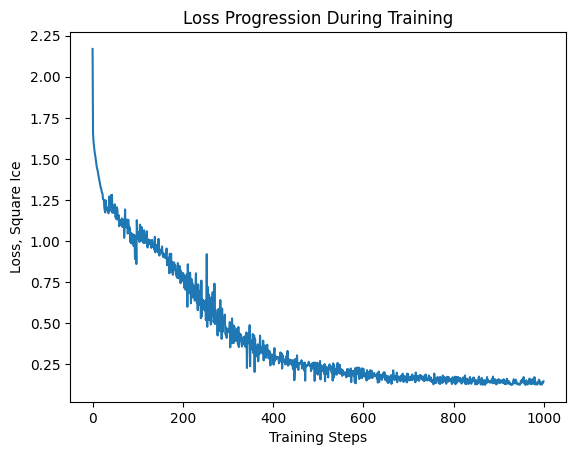

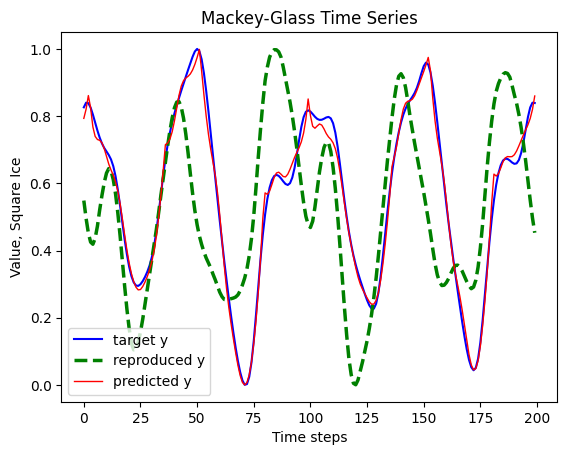

MODEL: Pinwheel
MSE: 0.0004658450840054158 
NRMSE: 0.021583444674226952 
CC : 0.9967662667249563


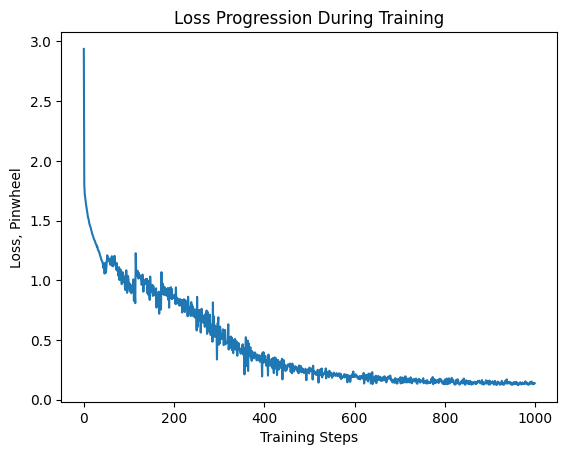

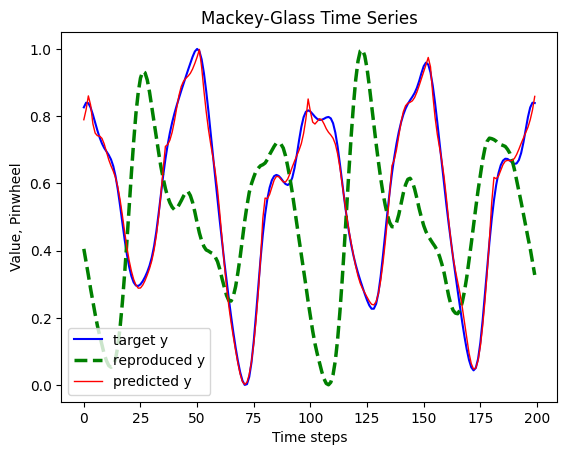

In [142]:
print("MODEL: Square Ice")

train_mse = mse(y_norm_train, y_pred_square)
train_nrmse = NRMSE(y_pred_square, y_norm_train)
train_cc = cc(y_norm_train, y_pred_square)
train_cc2 = compute_correlation_coefficient(y_norm_train, y_pred_square)
print("MSE:", train_mse, "\nNRMSE:", train_nrmse, "\nCC :", train_cc2)

# Plot the loss SQUARE
plt.plot(losses_square)
plt.xlabel("Training Steps")
plt.ylabel("Loss, Square Ice")
plt.title("Loss Progression During Training")
save_loss_name = 'losses_mg_square_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.png'
plt.savefig(save_loss_name)
plt.show()

# Plot the results SQUARE
plt.plot(y_norm_train[1300:1500], label="target y", color='blue')
plt.plot(y_reprod_square[1300:1500], label="reproduced y", linestyle='--', color='green', linewidth=2.5)
plt.plot(y_pred_square[1300:1500], label="predicted y", color='red', linewidth=1)
plt.xlabel("Time steps")
plt.ylabel("Value, Square Ice")
plt.title("Mackey-Glass Time Series")
plt.legend()
save_result_name = 'train_results_mg_square_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.png'
plt.savefig(save_result_name)
plt.show()

print("MODEL: Pinwheel")

train_mse = mse(y_norm_train, y_pred_pinwheel)
train_nrmse = NRMSE(y_pred_pinwheel, y_norm_train)
train_cc = cc(y_norm_train, y_pred_pinwheel)
train_cc2 = compute_correlation_coefficient(y_norm_train, y_pred_pinwheel)
print("MSE:", train_mse, "\nNRMSE:", train_nrmse, "\nCC :", train_cc2)

# Plot the loss PINWHEEL
plt.plot(losses_pinwheel)
plt.xlabel("Training Steps")
plt.ylabel("Loss, Pinwheel")
plt.title("Loss Progression During Training")
save_result_name = 'losses_mg_pinwheel_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.png'
plt.savefig(save_result_name)
plt.show()

# Plot the results PINWHEEL
plt.plot(y_norm_train[1300:1500], label="target y", color='blue')
plt.plot(y_reprod_pinwheel[1300:1500], label="reproduced y", linestyle='--', color='green', linewidth=2.5)
plt.plot(y_pred_pinwheel[1300:1500], label="predicted y", color='red', linewidth=1)
plt.xlabel("Time steps")
plt.ylabel("Value, Pinwheel")
plt.title("Mackey-Glass Time Series")
plt.legend()
save_result_name = 'train_results_mg_pinwheel_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.png'
plt.savefig(save_result_name)
plt.show()

MODEL: Square Ice
MSE: 0.0005833840374195518 
NRMSE : 0.024178209536870176 
CC: 0.9959047972697961


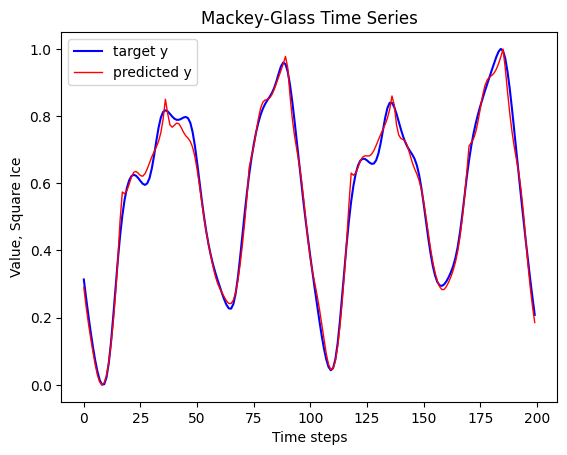

In [143]:
idx_start = 0
idx_disp = [300, 500]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_out = model_square(torch.tensor(X_square_test).to(device).float()).detach().cpu().numpy()[idx_start:]
test_out_max = np.max(test_out)
test_out_min = np.min(test_out)
test_out = (test_out - test_out_min) / (test_out_max - test_out_min)

test_mse = mse(y_norm_test, test_out)
test_nrmse = NRMSE(test_out, y_norm_test)
test_cc = cc(y_norm_test, test_out)
test_cc2 = compute_correlation_coefficient(y_norm_test, test_out)

y_pred_square_test = test_out
mse_square_test = test_mse
nrmse_square_test = test_nrmse
cc_square_test = test_cc2

print("MODEL: Square Ice")
print("MSE:", test_mse, "\nNRMSE :", test_nrmse, "\nCC:", test_cc2)

plt.plot(y_norm_test.flatten()[idx_start+idx_disp[0]:idx_start+idx_disp[1]], label="target y", color='blue')
plt.plot(test_out.flatten()[idx_disp[0]:idx_disp[1]], label="predicted y", color='red', linewidth=1)
plt.xlabel("Time steps")
plt.ylabel("Value, Square Ice")
plt.title("Mackey-Glass Time Series")
plt.legend()
save_result_name = 'test_results_mg_square_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.png'
plt.savefig(save_result_name)
plt.show()

MODEL: Pinwheel
MSE: 0.00047095811920697074 
NRMSE : 0.021723910773330607 
CC: 0.9968257614759626


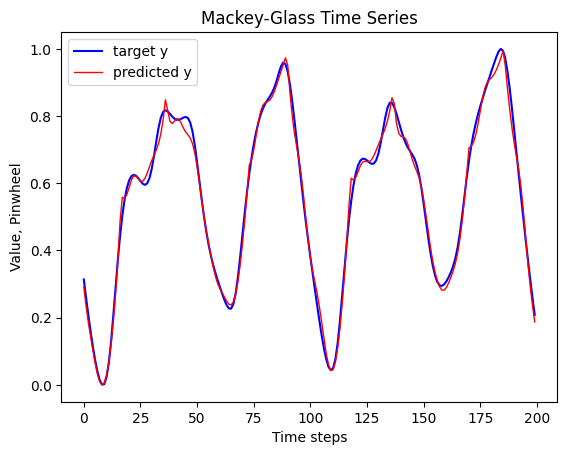

In [144]:
test_out = model_pinwheel(torch.tensor(X_pinwheel_test).to(device).float()).detach().cpu().numpy()[idx_start:]
test_out_max = np.max(test_out)
test_out_min = np.min(test_out)
test_out = (test_out - test_out_min) / (test_out_max - test_out_min)

test_mse = mse(y_norm_test, test_out)
test_nrmse = NRMSE(test_out, y_norm_test)
test_cc = cc(y_norm_test, test_out)
test_cc2 = compute_correlation_coefficient(y_norm_test, test_out)

y_pred_pinwheel_test = test_out
mse_pinwheel_test = test_mse
nrmse_pinwheel_test = test_nrmse
cc_pinwheel_test = test_cc2

print("MODEL: Pinwheel")
print("MSE:", test_mse, "\nNRMSE :", test_nrmse, "\nCC:", test_cc2)

plt.plot(y_norm_test[idx_start+idx_disp[0]:idx_start+idx_disp[1]], label="target y", color='blue')
plt.plot(test_out[idx_disp[0]:idx_disp[1]], label="predicted y", color='red', linewidth=1)
plt.xlabel("Time steps")
plt.ylabel("Value, Pinwheel")
plt.title("Mackey-Glass Time Series")
plt.legend()
save_result_name = 'test_results_mg_pinwheel_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.png'
plt.savefig(save_result_name)
plt.show()

In [145]:
import pickle

save_data_name = 'data_mg_'+str(history_len)+'_'+str(prediction_steps)+'_'+str(train_epochs)+'.pkl'
file = open(save_data_name, 'wb')

pickle.dump(y_norm_train, file)
pickle.dump(y_reprod_square, file)
pickle.dump(y_pred_square, file)
pickle.dump(losses_square, file)
pickle.dump(mse_square, file)
pickle.dump(nrmse_square, file)
pickle.dump(cc_square, file)
pickle.dump(y_reprod_pinwheel, file)
pickle.dump(y_pred_pinwheel, file)
pickle.dump(losses_pinwheel, file)
pickle.dump(mse_pinwheel, file)
pickle.dump(nrmse_pinwheel, file)
pickle.dump(cc_pinwheel, file)

pickle.dump(y_norm_test, file)
pickle.dump(y_pred_square_test, file)
pickle.dump(mse_square_test, file)
pickle.dump(nrmse_square_test, file)
pickle.dump(cc_square_test, file)
pickle.dump(y_pred_pinwheel_test, file)
pickle.dump(mse_pinwheel_test, file)
pickle.dump(nrmse_pinwheel_test, file)
pickle.dump(cc_pinwheel_test, file)

file.close()

load_hist_len = 50
load_pred_steps = 40
load_train_epochs = 20000

load_data_name = 'data_mg_'+str(load_hist_len)+'_'+str(load_pred_steps)+'_'+str(load_train_epochs)+'.pkl'
file = open(load_data_name, 'rb')

y_norm_train = pickle.load(file)
y_reprod_square = pickle.load(file)
y_pred_square = pickle.load(file)
losses_square = pickle.load(file)
mse_square = pickle.load(file)
nrmse_square = pickle.load(file)
cc_square = pickle.load(file)
y_reprod_pinwheel = pickle.load(file)
y_pred_pinwheel = pickle.load(file)
losses_pinwheel = pickle.load(file)
mse_pinwheel = pickle.load(file)
nrmse_pinwheel = pickle.load(file)
cc_pinwheel = pickle.load(file)

y_norm_test = pickle.load(file)
y_pred_square_test = pickle.load(file)
mse_square_test = pickle.load(file)
nrmse_square_test = pickle.load(file)
cc_square_test = pickle.load(file)
y_pred_pinwheel_test = pickle.load(file)
mse_pinwheel_test = pickle.load(file)
nrmse_pinwheel_test = pickle.load(file)
cc_pinwheel_test = pickle.load(file)

file.close()

print("Train, Square")
print("MSE:", mse_square, "\nNRMSE:", nrmse_square, "\nCC :", cc_square)
print("\nTrain, Pinwheel")
print("MSE:", mse_pinwheel, "\nNRMSE:", nrmse_pinwheel, "\nCC :", cc_pinwheel)

print("\nTest, Square")
print("MSE:", mse_square_test, "\nNRMSE:", nrmse_square_test, "\nCC :", cc_square_test)
print("\nTest, Pinwheel")
print("MSE:", mse_pinwheel_test, "\nNRMSE:", nrmse_pinwheel_test, "\nCC :", cc_pinwheel_test)

plt.plot(u_norm[train_len+history_len+idx_start+idx_disp[0]:train_len+history_len+idx_start+idx_disp[1]], label="input u", linestyle='--', color='green')
plt.plot(y_norm_test[idx_start+idx_disp[0]:idx_start+idx_disp[1]], label="target y", color='blue')
plt.plot(y_pred_square_test[idx_disp[0]:idx_disp[1]], label="predicted y", color='red', linewidth=1)
plt
plt.xlabel("Time steps")
plt.ylabel("Value, Square")
plt.title(r'Mackey-Glass Prediction, $\tau=$'+str(load_pred_steps))
plt.legend()
plt.show()

In [146]:
print(u_norm[train_len:].shape, y_norm_test.shape)

(952,) (902,)


In [147]:
print(np.max(test_out), np.min(test_out), test_out.shape)
print(test_out[1:20])
print(y_norm_test.shape)
print(y_norm_test[0:20])
print(y_norm_test[197:217])
print(y_norm_test[394:414])

1.0 0.0 (902, 1)
[[0.6682355 ]
 [0.62050855]
 [0.55985516]
 [0.49280235]
 [0.4298526 ]
 [0.37888113]
 [0.34037754]
 [0.3068063 ]
 [0.27227998]
 [0.23185933]
 [0.1852754 ]
 [0.13698474]
 [0.09366434]
 [0.06164641]
 [0.04553918]
 [0.04785794]
 [0.07055943]
 [0.11189035]
 [0.17062667]]
(902,)
[0.72198235 0.65947114 0.59793501 0.53865237 0.48229909 0.42897362
 0.37822586 0.32922173 0.28116091 0.23383254 0.18792879 0.144892
 0.10657062 0.07509168 0.05301693 0.04355425 0.05044477 0.07704756
 0.12447369 0.18981793]
[0.72349401 0.66100151 0.59944729 0.54012518 0.48372461 0.43035652
 0.37958077 0.33056613 0.28250285 0.23515983 0.1892085  0.14607909
 0.10761481 0.07593617 0.05359199 0.04377324 0.05021333 0.07629722
 0.12321387 0.18816525]
[0.72373787 0.66122631 0.59964476 0.54028944 0.48385257 0.43044858
 0.37964131 0.33060275 0.28252372 0.23517037 0.18920966 0.14606797
 0.1075858  0.07588132 0.05350072 0.04363261 0.05001067 0.0760265
 0.12288332 0.18779875]
